In [1]:
import cantera as ct
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

In [2]:
cti_file= '../../ammonia/base/cantera/chem_annotated.cti'
gas = ct.Solution(cti_file, "gas")
surf = ct.Interface(cti_file, "surface1", [gas])

In [3]:
ct.suppress_thermo_warnings()

#### Thermo of NH3(6) and N2(4) are ok
##### In many cases, when the change is on the order of a few percent, these discontinuities won't cause problems. However, if you notice a simulation failing at a consistent temperature for several conditions, this is one possible cause

<IPython.core.display.Javascript object>


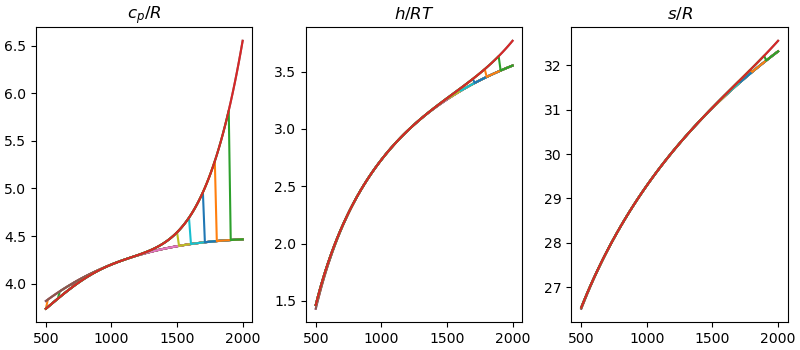

In [4]:
O2 = gas.species('O2(2)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(O2.thermo)

In [15]:
c0_O2[0] = 2000
test = ct.NasaPoly2(O2.thermo.min_temp, O2.thermo.max_temp, O2.thermo.reference_pressure, c0_O2)
plot_thermo(test)

In [5]:
c0_O2 = O2.thermo.coeffs
c0_O2[0] = 500
test = ct.NasaPoly2(O2.thermo.min_temp, O2.thermo.max_temp, O2.thermo.reference_pressure, c0_O2)
plot_thermo(test)
c0_O2[0] = 600
test = ct.NasaPoly2(O2.thermo.min_temp, O2.thermo.max_temp, O2.thermo.reference_pressure, c0_O2)
plot_thermo(test)
c0_O2[0] = 700
test = ct.NasaPoly2(O2.thermo.min_temp, O2.thermo.max_temp, O2.thermo.reference_pressure, c0_O2)
plot_thermo(test)

<IPython.core.display.Javascript object>


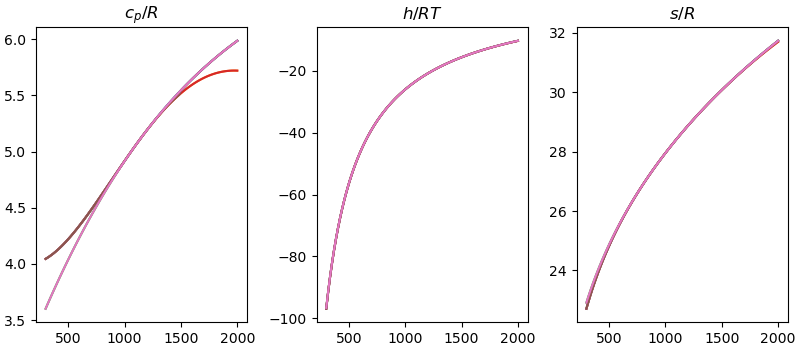

In [20]:
H2O = gas.species('H2O(3)')
T = np.linspace(300, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(H2O.thermo)

In [17]:
c0_H2O = H2O.thermo.coeffs
c0_H2O[0] = 500
test = ct.NasaPoly2(H2O.thermo.min_temp, H2O.thermo.max_temp, H2O.thermo.reference_pressure, c0_H2O)
plot_thermo(test)
c0_H2O[0] = 600
test = ct.NasaPoly2(H2O.thermo.min_temp, H2O.thermo.max_temp, H2O.thermo.reference_pressure, c0_H2O)
plot_thermo(test)
c0_H2O[0] = 700
test = ct.NasaPoly2(H2O.thermo.min_temp, H2O.thermo.max_temp, H2O.thermo.reference_pressure, c0_H2O)
plot_thermo(test)
c0_H2O[0] = 1500
test = ct.NasaPoly2(H2O.thermo.min_temp, H2O.thermo.max_temp, H2O.thermo.reference_pressure, c0_H2O)
plot_thermo(test)
c0_H2O[0] = 1700
test = ct.NasaPoly2(H2O.thermo.min_temp, H2O.thermo.max_temp, H2O.thermo.reference_pressure, c0_H2O)
plot_thermo(test)
c0_H2O[0] = 2000
test = ct.NasaPoly2(H2O.thermo.min_temp, H2O.thermo.max_temp, H2O.thermo.reference_pressure, c0_H2O)
plot_thermo(test)

<IPython.core.display.Javascript object>


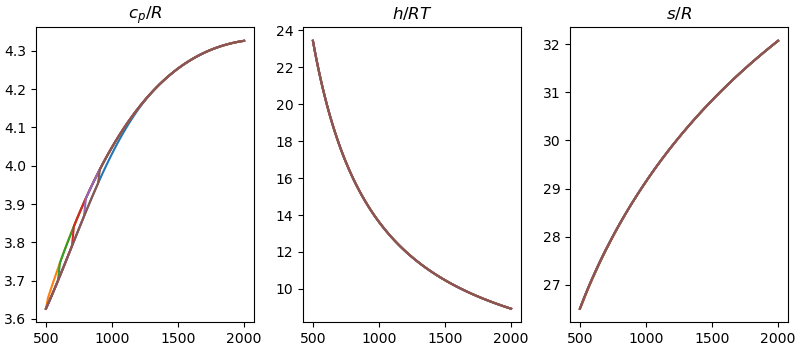

In [8]:
NO = gas.species('NO(5)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(NO.thermo)

In [9]:
c0_NO = NO.thermo.coeffs
c0_NO[0] = 500
test = ct.NasaPoly2(NO.thermo.min_temp, NO.thermo.max_temp, NO.thermo.reference_pressure, c0_NO)
plot_thermo(test)
c0_NO[0] = 600
test = ct.NasaPoly2(NO.thermo.min_temp, NO.thermo.max_temp, NO.thermo.reference_pressure, c0_NO)
plot_thermo(test)
c0_NO[0] = 700
test = ct.NasaPoly2(NO.thermo.min_temp, NO.thermo.max_temp, NO.thermo.reference_pressure, c0_NO)
plot_thermo(test)
c0_NO[0] = 800
test = ct.NasaPoly2(NO.thermo.min_temp, NO.thermo.max_temp, NO.thermo.reference_pressure, c0_NO)
plot_thermo(test)
c0_NO[0] = 900
test = ct.NasaPoly2(NO.thermo.min_temp, NO.thermo.max_temp, NO.thermo.reference_pressure, c0_NO)
plot_thermo(test)

<IPython.core.display.Javascript object>


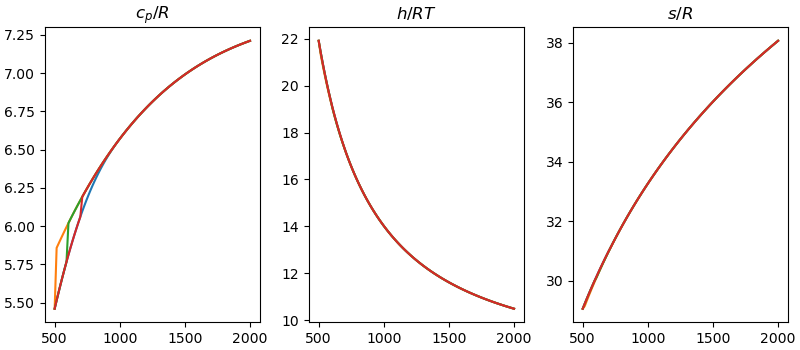

In [10]:
N2O = gas.species('N2O(7)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(N2O.thermo)

In [11]:
c0_N2O = N2O.thermo.coeffs
c0_N2O[0] = 500
test = ct.NasaPoly2(N2O.thermo.min_temp, N2O.thermo.max_temp, N2O.thermo.reference_pressure, c0_N2O)
plot_thermo(test)
c0_N2O[0] = 600
test = ct.NasaPoly2(N2O.thermo.min_temp, N2O.thermo.max_temp, N2O.thermo.reference_pressure, c0_N2O)
plot_thermo(test)
c0_N2O[0] = 700
test = ct.NasaPoly2(N2O.thermo.min_temp, N2O.thermo.max_temp, N2O.thermo.reference_pressure, c0_N2O)
plot_thermo(test)

<IPython.core.display.Javascript object>


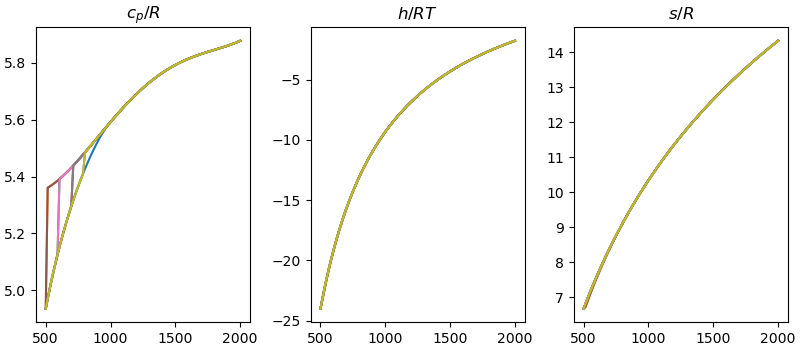

In [12]:
NOX = surf.species('NOX')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(NOX.thermo)

In [14]:
c0_NOX = NOX.thermo.coeffs
c0_NOX[0] = 500
test = ct.NasaPoly2(NOX.thermo.min_temp, NOX.thermo.max_temp, NOX.thermo.reference_pressure, c0_NOX)
plot_thermo(test)
c0_NOX[0] = 600
test = ct.NasaPoly2(NOX.thermo.min_temp, NOX.thermo.max_temp, NOX.thermo.reference_pressure, c0_NOX)
plot_thermo(test)
c0_NOX[0] = 700
test = ct.NasaPoly2(NOX.thermo.min_temp, NOX.thermo.max_temp, NOX.thermo.reference_pressure, c0_NOX)
plot_thermo(test)
c0_NOX[0] = 800
test = ct.NasaPoly2(NOX.thermo.min_temp, NOX.thermo.max_temp, NOX.thermo.reference_pressure, c0_NOX)
plot_thermo(test)

<IPython.core.display.Javascript object>


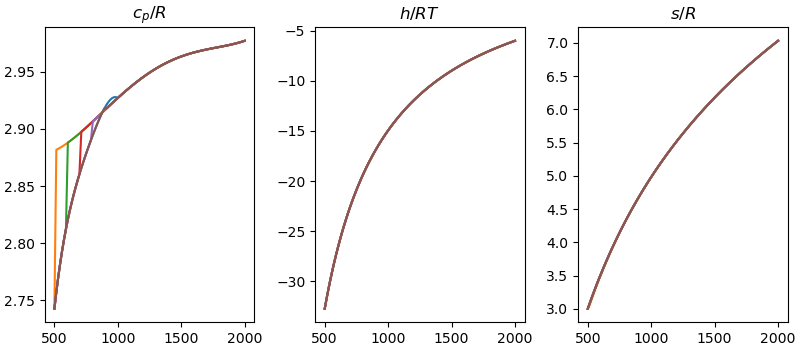

In [15]:
OX = surf.species('OX')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(OX.thermo)

In [16]:
c0_OX = OX.thermo.coeffs
c0_OX[0] = 500
test = ct.NasaPoly2(OX.thermo.min_temp, OX.thermo.max_temp, OX.thermo.reference_pressure, c0_OX)
plot_thermo(test)
c0_OX[0] = 600
test = ct.NasaPoly2(OX.thermo.min_temp, OX.thermo.max_temp, OX.thermo.reference_pressure, c0_OX)
plot_thermo(test)
c0_OX[0] = 700
test = ct.NasaPoly2(OX.thermo.min_temp, OX.thermo.max_temp, OX.thermo.reference_pressure, c0_OX)
plot_thermo(test)
c0_OX[0] = 800
test = ct.NasaPoly2(OX.thermo.min_temp, OX.thermo.max_temp, OX.thermo.reference_pressure, c0_OX)
plot_thermo(test)
c0_OX[0] = 900
test = ct.NasaPoly2(OX.thermo.min_temp, OX.thermo.max_temp, OX.thermo.reference_pressure, c0_OX)
plot_thermo(test)

<IPython.core.display.Javascript object>


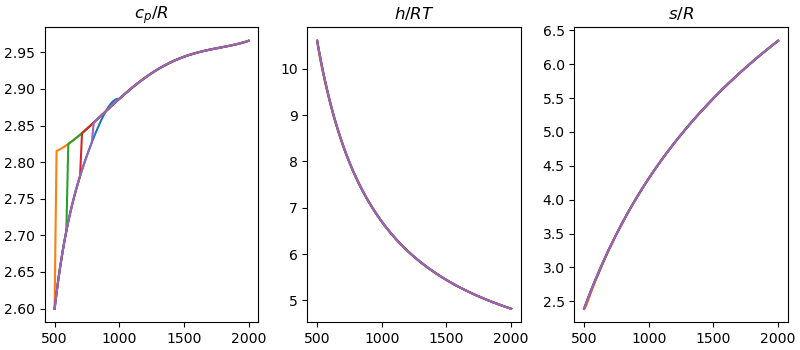

In [17]:
NX = surf.species('NX')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(NX.thermo)

In [18]:
c0_NX = NX.thermo.coeffs
c0_NX[0] = 500
test = ct.NasaPoly2(NX.thermo.min_temp, NX.thermo.max_temp, NX.thermo.reference_pressure, c0_NX)
plot_thermo(test)
c0_NX[0] = 600
test = ct.NasaPoly2(NX.thermo.min_temp, NX.thermo.max_temp, NX.thermo.reference_pressure, c0_NX)
plot_thermo(test)
c0_NX[0] = 700
test = ct.NasaPoly2(NX.thermo.min_temp, NX.thermo.max_temp, NX.thermo.reference_pressure, c0_NX)
plot_thermo(test)
c0_NX[0] = 800
test = ct.NasaPoly2(NX.thermo.min_temp, NX.thermo.max_temp, NX.thermo.reference_pressure, c0_NX)
plot_thermo(test)

<IPython.core.display.Javascript object>


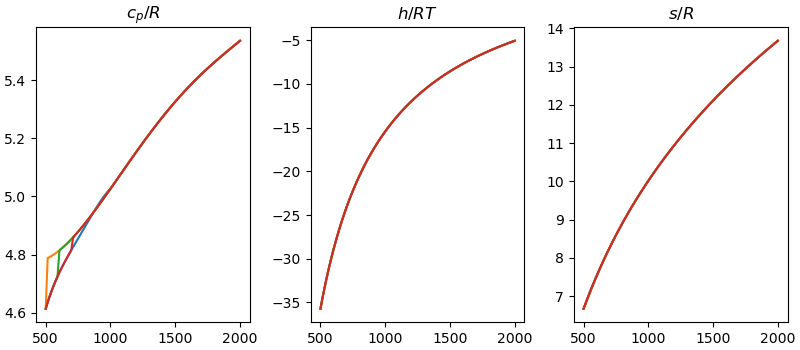

In [19]:
OHX = surf.species('OHX')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(OHX.thermo)

In [20]:
c0_OHX = OHX.thermo.coeffs
c0_OHX[0] = 500
test = ct.NasaPoly2(OHX.thermo.min_temp, OHX.thermo.max_temp, OHX.thermo.reference_pressure, c0_OHX)
plot_thermo(test)
c0_OHX[0] = 600
test = ct.NasaPoly2(OHX.thermo.min_temp, OHX.thermo.max_temp, OHX.thermo.reference_pressure, c0_OHX)
plot_thermo(test)
c0_OHX[0] = 700
test = ct.NasaPoly2(OHX.thermo.min_temp, OHX.thermo.max_temp, OHX.thermo.reference_pressure, c0_OHX)
plot_thermo(test)

<IPython.core.display.Javascript object>


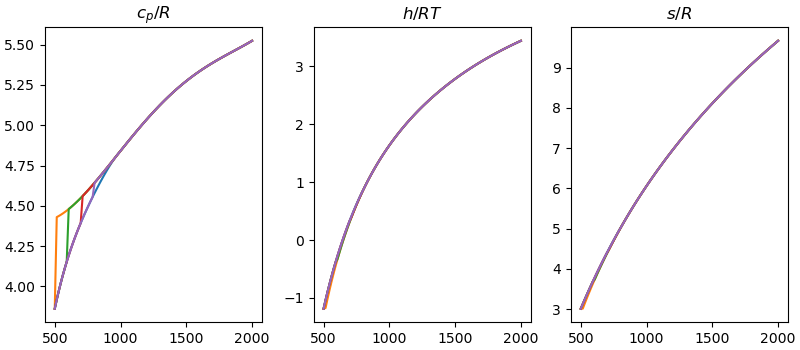

In [21]:
NHX = surf.species('NH_X(9)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(NHX.thermo)

In [22]:
c0_NHX = NHX.thermo.coeffs
c0_NHX[0] = 500
test = ct.NasaPoly2(NHX.thermo.min_temp, NHX.thermo.max_temp, NHX.thermo.reference_pressure, c0_NHX)
plot_thermo(test)
c0_NHX[0] = 600
test = ct.NasaPoly2(NHX.thermo.min_temp, NHX.thermo.max_temp, NHX.thermo.reference_pressure, c0_NHX)
plot_thermo(test)
c0_NHX[0] = 700
test = ct.NasaPoly2(NHX.thermo.min_temp, NHX.thermo.max_temp, NHX.thermo.reference_pressure, c0_NHX)
plot_thermo(test)
c0_NHX[0] = 800
test = ct.NasaPoly2(NHX.thermo.min_temp, NHX.thermo.max_temp, NHX.thermo.reference_pressure, c0_NHX)
plot_thermo(test)

<IPython.core.display.Javascript object>


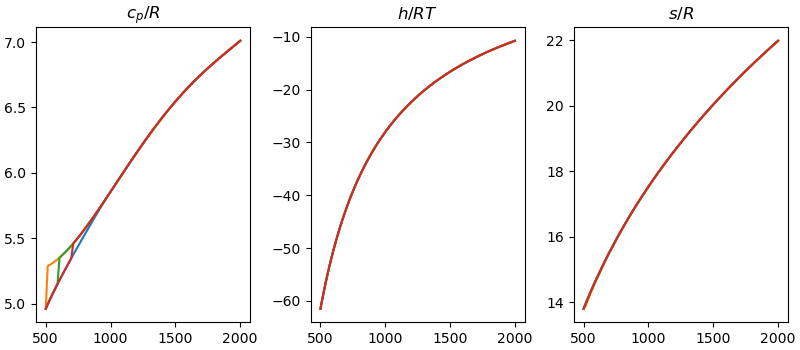

In [23]:
H2OX = surf.species('H2O_X(11)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(H2OX.thermo)

In [24]:
c0_H2OX = H2OX.thermo.coeffs
c0_H2OX[0] = 500
test = ct.NasaPoly2(H2OX.thermo.min_temp, H2OX.thermo.max_temp, H2OX.thermo.reference_pressure, c0_H2OX)
plot_thermo(test)
c0_H2OX[0] = 600
test = ct.NasaPoly2(H2OX.thermo.min_temp, H2OX.thermo.max_temp, H2OX.thermo.reference_pressure, c0_H2OX)
plot_thermo(test)
c0_H2OX[0] = 700
test = ct.NasaPoly2(H2OX.thermo.min_temp, H2OX.thermo.max_temp, H2OX.thermo.reference_pressure, c0_H2OX)
plot_thermo(test)

<IPython.core.display.Javascript object>


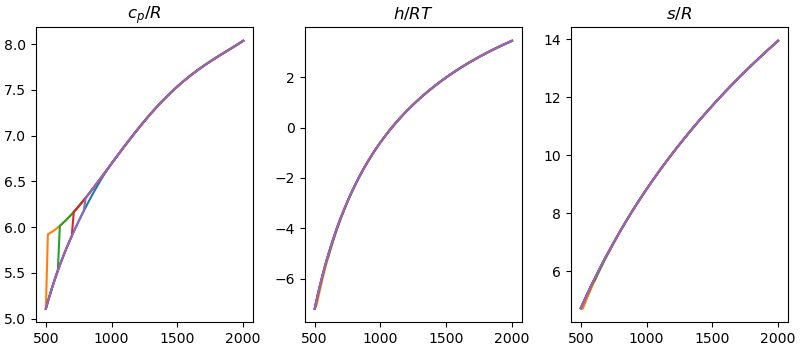

In [25]:
NH2X = surf.species('NH2_X(8)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(NH2X.thermo)

In [26]:
c0_NH2X = NH2X.thermo.coeffs
c0_NH2X[0] = 500
test = ct.NasaPoly2(NH2X.thermo.min_temp, NH2X.thermo.max_temp, NH2X.thermo.reference_pressure, c0_NH2X)
plot_thermo(test)
c0_NH2X[0] = 600
test = ct.NasaPoly2(NH2X.thermo.min_temp, NH2X.thermo.max_temp, NH2X.thermo.reference_pressure, c0_NH2X)
plot_thermo(test)
c0_NH2X[0] = 700
test = ct.NasaPoly2(NH2X.thermo.min_temp, NH2X.thermo.max_temp, NH2X.thermo.reference_pressure, c0_NH2X)
plot_thermo(test)
c0_NH2X[0] = 800
test = ct.NasaPoly2(NH2X.thermo.min_temp, NH2X.thermo.max_temp, NH2X.thermo.reference_pressure, c0_NH2X)
plot_thermo(test)

<IPython.core.display.Javascript object>


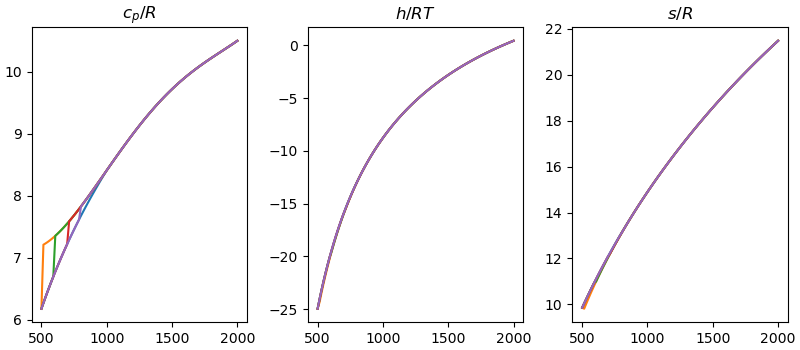

In [27]:
NH3X = surf.species('NH3X')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(NH3X.thermo)

In [42]:
c0_NH3X = NH3X.thermo.coeffs
c0_NH3X[0] = 500
test = ct.NasaPoly2(NH3X.thermo.min_temp, NH3X.thermo.max_temp, NH3X.thermo.reference_pressure, c0_NH3X)
plot_thermo(test)
c0_NH3X[0] = 600
test = ct.NasaPoly2(NH3X.thermo.min_temp, NH3X.thermo.max_temp, NH3X.thermo.reference_pressure, c0_NH3X)
plot_thermo(test)
c0_NH3X[0] = 700
test = ct.NasaPoly2(NH3X.thermo.min_temp, NH3X.thermo.max_temp, NH3X.thermo.reference_pressure, c0_NH3X)
plot_thermo(test)
c0_NH3X[0] = 800
test = ct.NasaPoly2(NH3X.thermo.min_temp, NH3X.thermo.max_temp, NH3X.thermo.reference_pressure, c0_NH3X)
plot_thermo(test)
c0_NH3X[0] = 400
test = ct.NasaPoly2(NH3X.thermo.min_temp, NH3X.thermo.max_temp, NH3X.thermo.reference_pressure, c0_NH3X)
plot_thermo(test)

<IPython.core.display.Javascript object>


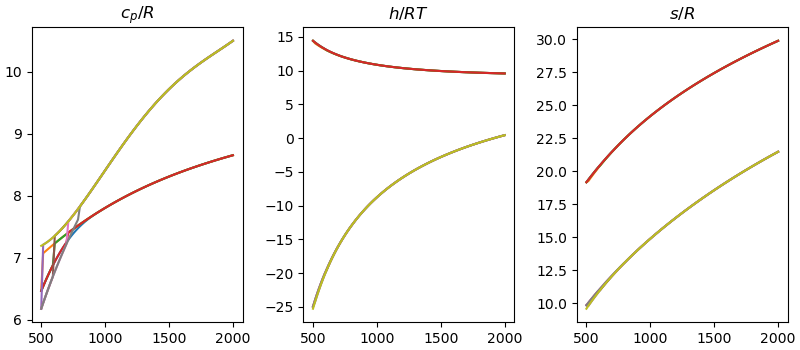

In [40]:
N2OX = surf.species('N2O_X(51)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(N2OX.thermo)

In [41]:
c0_N2OX = N2OX.thermo.coeffs
c0_N2OX[0] = 500
test = ct.NasaPoly2(N2OX.thermo.min_temp, N2OX.thermo.max_temp, N2OX.thermo.reference_pressure, c0_N2OX)
plot_thermo(test)
c0_N2OX[0] = 600
test = ct.NasaPoly2(N2OX.thermo.min_temp, N2OX.thermo.max_temp, N2OX.thermo.reference_pressure, c0_N2OX)
plot_thermo(test)
c0_N2OX[0] = 700
test = ct.NasaPoly2(N2OX.thermo.min_temp, N2OX.thermo.max_temp, N2OX.thermo.reference_pressure, c0_N2OX)
plot_thermo(test)

In [33]:
gas.TPX = 623, 101325, 'NH3(6):0.066, O2(2):0.88,He:0.054'
gas.equilibrate('TP')
gas()


  gas:

       temperature             623  K
          pressure          101325  Pa
           density         0.56767  kg/m^3
  mean mol. weight         29.0203  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -4.6942e+05       -1.362e+07     J
   internal energy     -6.4792e+05        -1.88e+07     J
           entropy          7814.3        2.268e+05     J/K
    Gibbs function     -5.3377e+06       -1.549e+08     J
 heat capacity c_p            1102        3.198e+04     J/K
 heat capacity c_v          815.44        2.366e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                He      0.0531235       0.00732702         -18.6467
             O2(2)       0.817019         0.900875         -25.6542
            H2O(3)       0.097393        0.0604599         -72.5897
             N2(4)      0.03

<IPython.core.display.Javascript object>


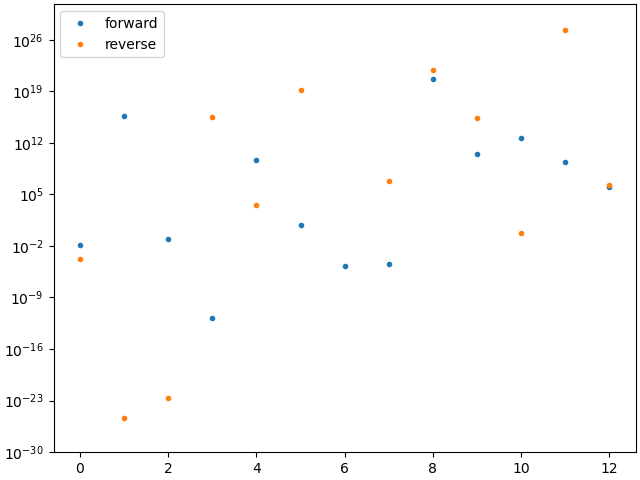

In [20]:
f, ax = plt.subplots()
ax.semilogy(surf.forward_rate_constants, '.', label='forward')
ax.semilogy(surf.reverse_rate_constants, '.', label='reverse')
ax.axis(ymin=1e-30)
ax.legend();

In [31]:
kr = surf.reverse_rate_constants
for i, k in enumerate(kr):
    if k > 1e-99:
        print(f'{i:4d}  {k:.4e}  {surf.reaction_equation(i)}')

   0  1.7224e-04  NX + OX <=> NOX + X(1)
   1  3.7451e-26  O2(2) + 2 X(1) <=> 2 OX
   2  2.2522e-23  2 NX <=> N2(4) + 2 X(1)
   3  2.9577e+15  NOX <=> NO(5) + X(1)
   4  3.5374e+03  NH3(6) + X(1) <=> NH3X
   5  1.5351e+19  NOX + NX <=> N2O(7) + 2 X(1)
   6  1.3561e-43  N2O(7) + X(1) <=> N2(4) + OX
   7  6.2614e+06  NH3X + OX <=> NH2_X(8) + OHX
   8  8.1199e+21  NH2_X(8) + OX <=> NH_X(9) + OHX
   9  2.7065e+15  NH_X(9) + OX <=> NX + OHX
  10  5.1876e-01  NH_X(9) + OHX <=> H2O_X(11) + NX
  11  2.1060e+27  H2O_X(11) + OX <=> 2 OHX
  12  1.6963e+06  H2O_X(11) <=> H2O(3) + X(1)


In [28]:
kf = surf.forward_rate_constants
for i, k in enumerate(kf):
    if k > 1e20:
        print(f'{i:4d}  {k:.4e}  {surf.reaction_equation(i)}')

   8  4.0300e+20  NH2_X(8) + OX <=> NH_X(9) + OHX
